In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import json

In [7]:
def load_something(loader, path):
    with open(path, "r") as f:
        return loader(f)

def parse_epoch_idx(epoch_info, key):
    if "-" in key:
        a, b = key.split("-")
    elif "." in key:
        a, b = key.split(".")
    else:
        a, b = key, None

    if b is not None: # Mini-epoch
        epoch_len = int(epoch_info[key]["epoch_len"])
        return int(a) + int(b) / epoch_len
    else: # Full epoch
        return int(a)+1

def load_histories(paths, prefix=None):
    result = []
    processed_paths = []
    for p in paths:
        if prefix:
            p = os.path.join(prefix, p)
        path_glob = glob.glob(p)
        if not path_glob:
            print("Failed to load path:", p)
        processed_paths.extend(path_glob)
    for p in processed_paths:
        hist_file = os.path.join(p, "epoch_history.json")
        if os.path.exists(hist_file):
            name = os.path.basename(p)
            epoch_info = load_something(json.load, hist_file)
            train_x = []
            train_y = []
            val_x = []
            val_y = []
            energy_x = []
            energy_y = []
            force_x = []
            force_y = []
            for ek, ev in epoch_info.items():
                if "mini_train_loss" in ev:
                    train_x.append(parse_epoch_idx(epoch_info, ek))
                    train_y.append(ev["mini_train_loss"])
                if "val_loss" in ev:
                    val_x.append(parse_epoch_idx(epoch_info, ek))
                    val_y.append(ev["val_loss"])
                if "energy_loss" in ev:
                    energy_x.append(parse_epoch_idx(epoch_info, ek))
                    energy_y.append(ev["energy_loss"])
                if "force_loss" in ev:
                    force_x.append(parse_epoch_idx(epoch_info, ek))
                    force_y.append(ev["force_loss"])
            data = {
                "train_x":train_x,
                "train_y":train_y,
                "val_x":val_x,
                "val_y":val_y,
                "energy_x":energy_x,
                "energy_y":energy_y,
                "force_x":force_x,
                "force_y":force_y,
                "name":name,
            }
            result.append(data)
        else:
            print("Failed to load history:", p)
    return result

In [8]:
data_directory_prefix = None
result_list = [
    # "/home/argon/Stuff/seq_embedding/model_single_chain_2024.06.26_subsetC_CA_lj_angleXCX_dihedralX_cutoff2_seq6__wd0_explr5en4_0.95_bs4",
    "/home/md-ml/awaghili/cgschnet/cgschnet/data/result-2025.01.12-13.48.33",
    ]

data = load_histories(result_list, data_directory_prefix)

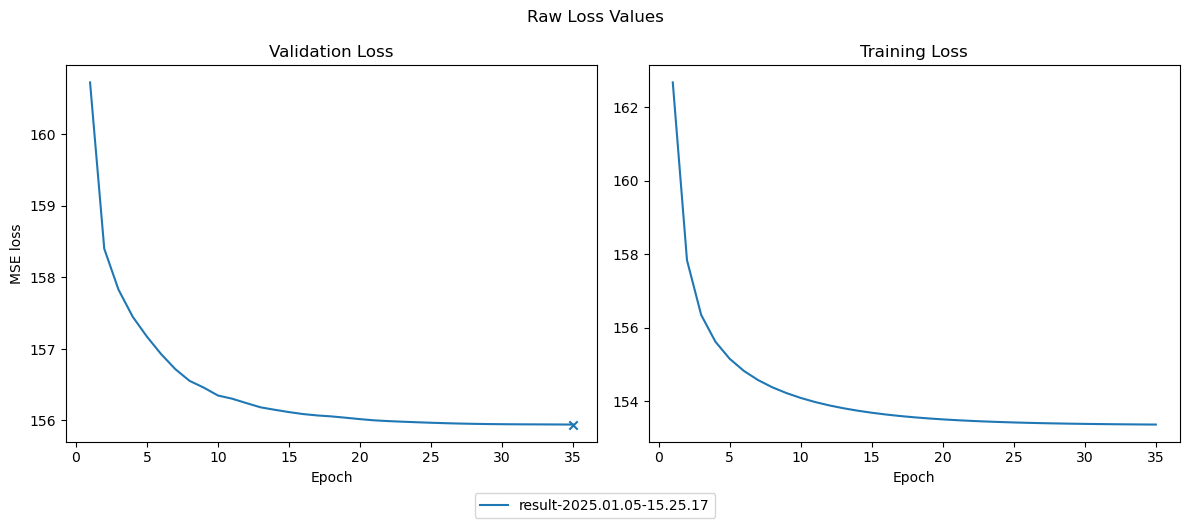

In [9]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 5))
fig.suptitle('Raw Loss Values')

best_val_loss = []

for history in data:
    ax1.plot(history["val_x"], history["val_y"])
    ax1.set_title(f"Validation Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("MSE loss")

    ax2.plot(history["train_x"], history["train_y"], label=history['name'])
    ax2.set_title(f"Training Loss")
    ax2.set_xlabel("Epoch")

    ax3.plot(history["energy_x"], history["energy_y"])
    ax3.set_title(f"Energy Loss")
    ax3.set_xlabel("Epoch")
    
    ax4.plot(history["force_x"], history["force_y"])
    ax4.set_title(f"Force Loss")
    ax4.set_xlabel("Epoch")

    
    if history["val_y"]:
        best_idx = np.argmin(history["val_y"])
        best_val_loss.append((history["val_x"][best_idx], history["val_y"][best_idx]))
    else:
        best_val_loss.append((None, None))

# Mark the lowest validation loss with an x
for x, y in best_val_loss:
    ax1.scatter([x],[y],marker="x")

fig.tight_layout()
fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.05*len(data)))
pass